<h1>Probabilistic Multitarget Tracking</h1>

The following tutorial will be explained, then expanded on in regards to multi-target tracking: https://pyro.ai/examples/tracking_1d.html

<h2>Intro- Running the Code</h2>

First, to be able to run the tutorial, the following was done to create a runnable environment:
1. Create an environment using anaconda
2. Open a terminal using this environment
3. Install pytorch by running in the terminal _conda installpytorch torchvision -c pytorch_
4. Install pyro by running in the terminal _pip3 install pyro-ppl_

Two things were added to the code base to be able to make it run out of a terminal:
1. The following code was added due to this [stack overflow error recommendation](https://stackoverflow.com/questions/20554074/sklearn-omp-error-15-when-fitting-models):
<pre><code>
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
</code></pre>
2. The code line _pyplot.show()_ at the end of the plot_solution function so the plots would display outside of a Jupyter notebook. 

With the following command:
_python track1D.py_ 
I am able to run the code from the tutorial. I did not change the structure until I adapt it to my purposes. Next, I make the points worth noting in what is being run before I adapt and expand the code to different scenarios.


In [34]:
#using pathlib
from pathlib import Path

file_name = Path("./ProbabilisticTracking")
if file_name.exists():
    print("ProbabilisticTracking already exists, skipping cloning")
else:
    !git clone https://github.com/kstisser/ProbabilisticTracking


Cloning into 'ProbabilisticTracking'...


In [38]:
!ls ./
!cd ./ProbabilisticTracking/Project/

'ls' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


In [7]:
%matplotlib inline
!python track1D.py

generated 12 detections from 2 objects
Figure(1200x600)
epoch    0 loss = 191.8911590576172
epoch   10 loss = 181.39599609375
epoch   20 loss = 177.9198760986328
epoch   30 loss = 180.06930541992188
epoch   40 loss = 177.4243621826172
epoch   50 loss = 178.504638671875
epoch   60 loss = 175.1251220703125
epoch   70 loss = 177.17071533203125
epoch   80 loss = 179.46656799316406
epoch   90 loss = 178.46363830566406
epoch  100 loss = 177.4864501953125
Figure(640x480)
Figure(1200x600)


<h2>Original Code Breakdown</h2>

Dynamics being used for targets are deterministic (sin/cos) where the period is known but the phase and amplitude are unknown.

The following arguments are set at the beginning for this system:
* Number of frames
* Max number of objects
* Expected number of objects
* Expected number of spurious targets
* Probability of emission
* Emission noise scale

A seed is set so the results can be reproducible

The code is broken up into the following components:
1. Data Generation
2. Model
3. Guide
4. SVI/Train
5. Plot Solutions

Let's look at each of these separately:
<h3>Data Generation</h3>
* 5 frames of position data is generated for the expected number of objects (2), and given sinusoidal movement, captured with a sin and cos element per target per time frame. Noise is added to these positions based on the emissions_noise_scale parameter.

* Whether the data was detected (or emitted) by a sensor was modeled based on a Bernoulli distribution. 

* "Spurious" returns, or sensor returns that are received but not real targets are modeled using the Poisson distribution. 

* The Observations variable is generated (Number of frames x number of detections x 2) This data holds both a position and a confidence for each detection at each time frame.

* The "states" variable gives variety to the position location for each object, as they all have a deterministic sinusoidal movement

<h3>Model Guide Relationship</h3>
In reading [this post](https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886) I found that in Pyro the guide-model relationship is that the model is a distribution to be learned. The guide is also a distribution to be learned that is very close to the model, but is much easier to compute, as in his diagram here:

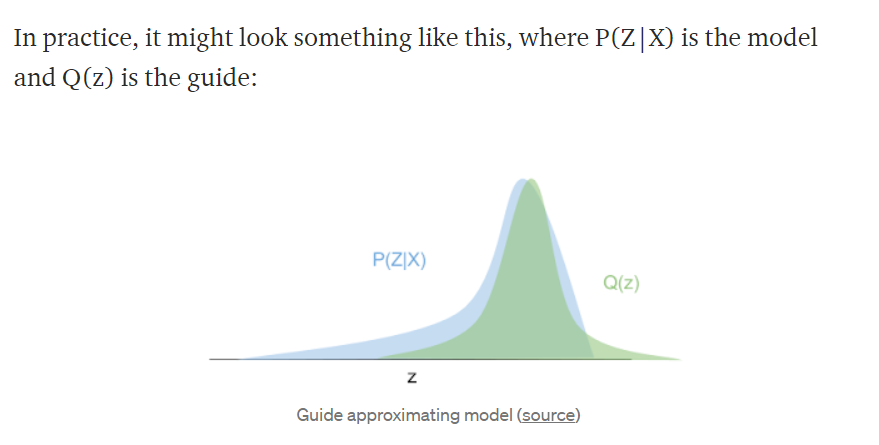

The parameters in the guide replace the parameters in the model as they are learned in each iteration, and the guide follows the model around, trying to accurately represent the distribution in the model. 

<h3>Model</h3>
The model:

* Loops through a plate of objects

    * Inside of the object plate it creates a Bernoulli distribution of whether an object **exists**
    
        * With a mask of the exists distribution, positions are generated using a variable **states** which helps determine their actual locations when applied to their sinusoidal predetermined dynamics
        
* Loops through a plate of detections

    * Loops through a plate of time frames
    
        * With a mask of whether the detection was observed **assign** is made as a categorical distribution ranging from 0 to the max number of objects to represent which target the observation came from
        
        * **is_spurious** is made with a Bernoulli distribution, initialized with a 1/(max # of objects) probability
        
        * **is_real** is made with a Bernoulli distribution, and set to True if the observation is_observed and !is_spurious
        
        * If the detection is_real (mask), predicted positions are made based on assignments and pregenerated positions based on states. **real_observations** is made by a Normal distribution for observations given the emission noise and the observed positions
        
        * If the detection is_spurious (mask) **spurious_observations** are made based on the Normal distribution given observed positions


**Note- Bold variables above are the variables the model is aiming to learn**

<h3>Guide</h3>
This is also known as the variational distribution. It acts as an approximation to the posterior.

* The guide starts by initializing the states randomly from the prior using the **states\_loc** and the **states\_scale** which uses the emission_noise_scale parameter and the dynamic generation function

* A Normal distribution is made for the positions as real_dist, using emission_noise_scale as the standard deviation

* spurious_dist is made into a Normal distribution between 0 and 1

* probability of assignment is calculated using the following equation:

$$
assign\_logits = logp(real\_dist | observed\_positions) - logp(spurious\_dist | observed\_positions) + log(\frac{expected\_num\_objects * emission\_prob}{expected\_num\_spurious})
$$

* All unobserved probability is overwritten to be -inf

* The probability of existing is calculated with the following equation:

$$
exists\_logits = log(\frac{max\_num\_objects}{expected\_num\_objects})
$$

* assignment is calculated with the [MarginalAssignmentPersistent](https://docs.pyro.ai/en/0.3.1/_modules/pyro/contrib/tracking/assignment.html) using the exists\_logits and the assign\_logits. This is the data association step, which is performed using the data from multiple frames which contain multiple persistent objects. Inputs are factors in a factor graph, which both contains existence probabilities for each potential object, and assignment probabilities for each object-detection pair. The outputs are the marginal distributions of posterior existence probability of each potential object and posterior assignment probabilities of each object-detection pair. To allow this to handle a variable number of detections, the unobserved detections were set to -inf. 

* MarginalAssignmentPersistent uses the underlying function compute_marginals_persistent (computationally expensive, used just for testing) and compute_marginals_persistent_bp (uses loopy belief propogation). 

* compute_marginals_persistent implements exact inference of pairwise marginals via enumeration. It loops through frames, detections, and permutations, and creates an assignment map. probability of assignment is conditioned on the probability of existing. 

* compute_marginals_persistent_bp implements approximate inference of pairwise marginals via loopy belief propogation. It loops through the belief propogation to assign message connections.     # This implements forward-backward message passing among three sets of variables:
    
$$
a[t,j] = Categorical(num\_objects + 1), detection -> object assignment
$$
       
$$
b[t,i] = Categorical(num\_detections + 1), object -> detection assignment
$$
       
 $$
 e[i] = Bernonulli, whether each object exists
 $$
    
     * Only assign = a and exists = e are returned.



**Note- Bold variables above are the variables the guide is aiming to learn**

<h3>SVI/Train</h3>

* The training is done using the pyro [SVI](https://docs.pyro.ai/en/dev/inference_algos.html). This calculates stochastic variational inference using:

    * A defined model, as explained above

    * A defined guide, as explained above

    * Adam optimizer with learning rate 0.01. This a standard choice for best optimizer.

    * TraceEnum_ELBO loss function with max_plate_nesting of 2
    
           * ELBO is a lower bound to the log evidence for all choices of parameters used in the model and variational parameters used in the guide
           
           * As we take stochastic gradient steps to maximize the ELBO, we push the log evidence higher, and the gap between the two is the KL divergence between the guide and the posterior. 

* Training is performed on 101 epochs, optimizing based on the loss function, and capturing the data so it can be plotted later.

* Each step takes a single gradient step and returns an estimate of the loss minus the ELBO. Arguments are piped to the model and guide functions. 

[ref](https://pyro.ai/examples/svi_part_i.html)

<h3>Plot Solutions</h3>
What's plotted here are:
* Losses at every 10th epoch

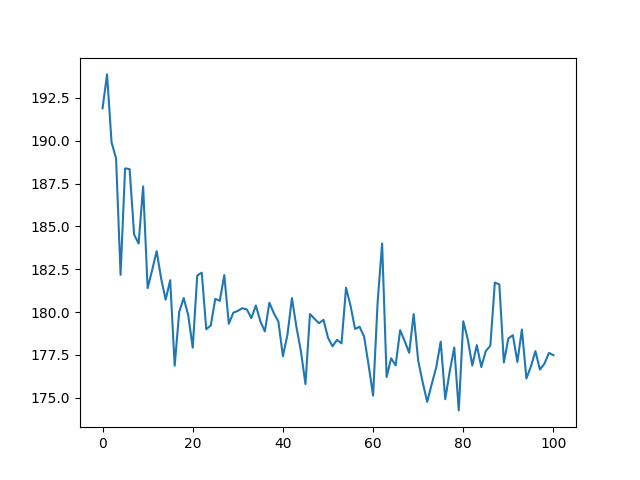

* Position vs Time Step for Truth, Predictions, and Observations (before training)
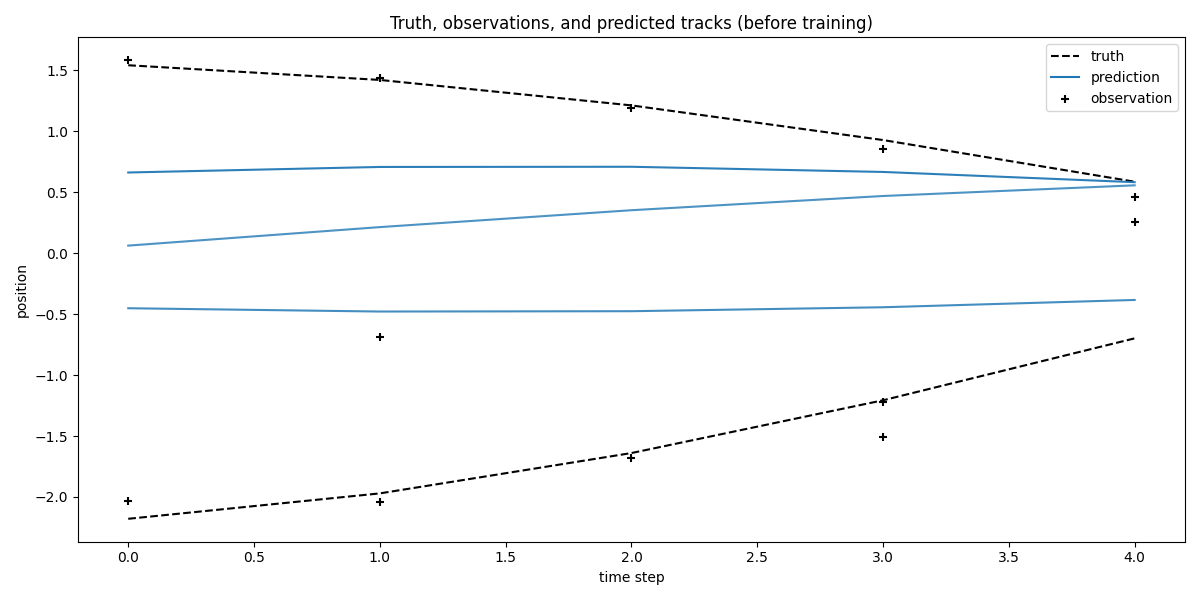


* Position vs Time Step for Truth, Predictions, and Observations (after training)
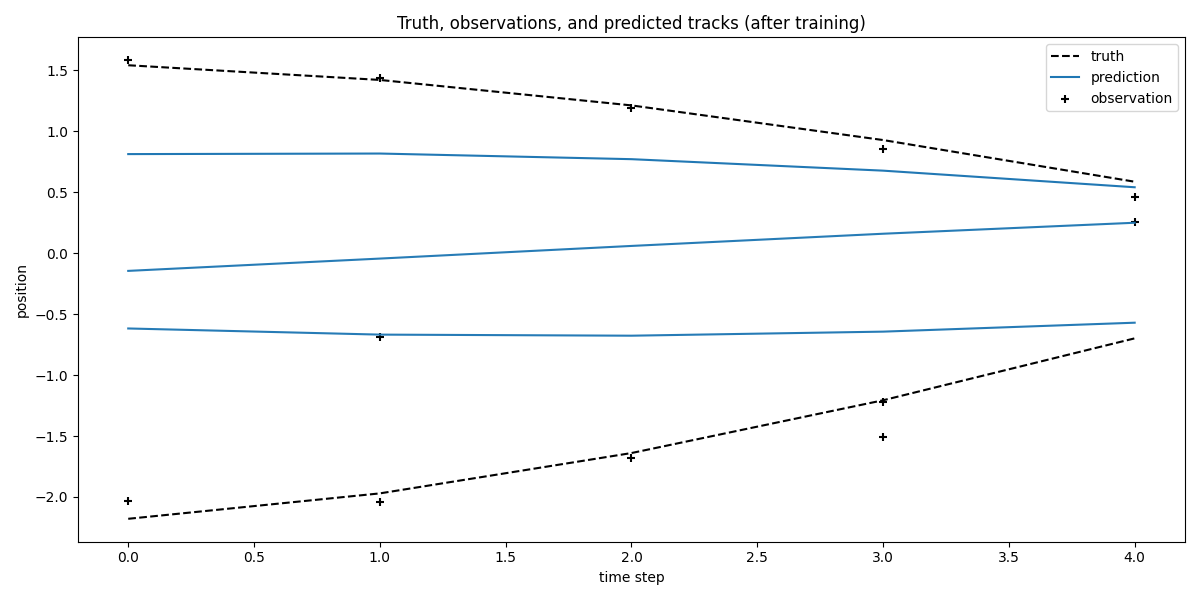


<h2>Practical Problems</h2>

This is a very simple get off the ground running explanation. 

However, based on my years of experience working on a real world multi-target tracking problem for an autonomous delivery bot, I notice several aspects that would need to be changed and adapted to work in the real world. I will note many that I notice, and adapt the code for a few of them. 

1. **Sinusoidal movement**- while this may work for tracking certain things like a pendulum, this is not an anticipated trajectory for most things in the real world. The first adaptation would be for linear movement. This could be further adapted to be more complex to handle different movement models for different types of objects, like cars and pedestrians. **This is a prerequisite for using NuScenes data.**

2. **1 Dimensional tracking**- The real world is 3D, and tracking should be adapted to be in a 3D x,y,z coordinate system. Size of an object could also be considered as another dimension to track, as it's important for autonomous vehicles to know to avoid collision. **This is a prerequisite for using NuScenes data.**

3. **Running Online**- Adapting this code to be able to handle new data to run online would be important. 

4. **Accumulated data**- num\_observed continues to accumulate over all time frames. A window of data to be considered would be more practical, as robots will likely run at a speed and length, taking in a certain number of targets that you would run out of memory, exceed the limits of an int and produce bogus values, or run slower than real time.

5. **Real Dataset**- This would need to be adapted to consider a real dataset, for instance [NuScenes](https://www.nuscenes.org/). Alternatively another generated dataset could be used for linear movement if wanting to start easier.

6. **Multiple points per target**- It is highly likely you will get multiple points per target if using lidar or radar. This is a prerequisite for using NuScenes data.

7. **Multiple Data Sources**- Which sensor the data comes from makes a difference, as each sensor has areas where they excel at or struggle with. For instance:

    * Lidar- this provides many points per target and is most precise. The ideal range depends on the sensor, but Velodyne for instance is great at a few meters away, and tends to be sparse further away. It also is less precise in inclement weather. 
    
    * Radar- this provides very good measurements in inclement weather but is less precise than lidar. It also provides velocity information based on the doppler effect. It gives more sparse returns though. For instance, it may only return one point every 5 feet. This spec obviously depends on the radar. But, this makes it hard to differentiate between different objects as there may only be one return between two objects. There may also be multiple returns for large objects like buses with different velocities, especially if the bus is in the middle of a turn. 
    
    * Camera- this is great for being able to differentiate the type of object and number of objects in the frame. It does depend on sufficient ambient lighting and is difficult to find accurate range of objects in an image with only a single camera. 
    
Each sensor can be used and fused with the information of the other sensors to enhance the overall prediction of targets. For instance, the probability of accuracy of one component increases if the return is from one sensor verses another. (This is optional but improves the output for NuScenes data).

8. **Object type considered**- If multiple objects are being tracked which object type the object is (car, bicycle, pedestrian...) should be considered and conditioned on when deciding the probability of association between detections or returns. (This is optional but improves the output for NuScenes data).

9. **Kalman Filter Tracking**- A Kalman Filter (linear) or Unscented Kalman Filter (Nonlinear) should be used to track the trajectory of each target, and the history of the tracking should be considered when computing the probability of the association with this track. (This is optional but improves the output for NuScenes data).

10. **Adding Birth & Death of targets**- Currently we are just assuming there is a constant number of persistent targets. However, we need the ability to adapt to we can create new targets (Birth) when a new person walks out from behind a building, or a new car turns onto our street. We also need to be able to stop tracking a target (Death) when we are confident we are no longer getting returns or detections from that target. Maybe a person walked behind or inside of a building, or into a car. Maybe a car turned down a different street. The data association function would likely need to be adapted for this function, and **this would be a prerequisite for using NuScenes data.**

<h2>Adaptations</h2>

My initial focus for adaptations will be on 1, 2, & 5(simpler generated linear dataset) from above. Code segments and changes will be more thoroughly explained as it is adapted. 

<h2>Adaptation Steps</h2>

* Note- when only changing the number of frames from 5 to 20, the code broke in SVI, so something may be hard coded. However, before breaking, the following image was able to be generated before training. This shows more of the sinusoidal movement:
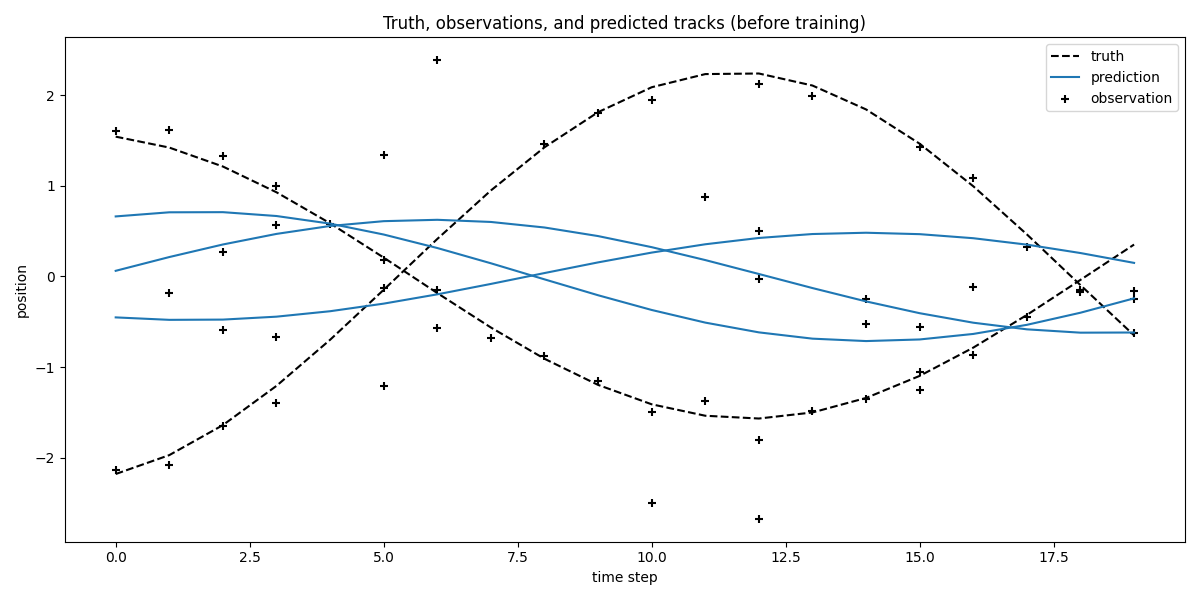

I was, however, able to change the number of expected targets and number of max targets and still run the code. 